In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
arith_rgb_to_gray = pd.read_csv("../bench/arith_rgb_to_gray.csv")
linalg_assoc = pd.read_csv("../bench/linalg_assoc.csv")
math_inv_sqrt = pd.read_csv("../bench/math_inv_sqrt.csv")
math_horners_method = pd.read_csv("../bench/math_horners_method.csv")

In [61]:
# combine "-O0" col from all dataframes into one dataframe
df = pd.concat([arith_rgb_to_gray, linalg_assoc, math_inv_sqrt, math_horners_method], ignore_index=True)
df

,name,opt,-O0,-O1,-O2,-O3
0,arith_rgb_to_gray,canon,52587.5,21417.0,20399.0,20585.0
1,arith_rgb_to_gray,canon+eqsat,45576.0,19885.0,18680.5,20892.5
2,arith_rgb_to_gray,eqsat+canon,45070.5,22433.5,19305.5,19392.0
3,arith_rgb_to_gray,noopt,46079.0,21888.5,19717.5,21753.5
4,arith_rgb_to_gray,eqsat,45365.5,21178.5,23935.0,19457.5
5,linalg_assoc,eqsat,59.5,14.5,14.0,14.0
6,linalg_assoc,noopt,738.5,120.0,121.0,119.0
7,linalg_assoc,canon,746.5,120.0,121.0,121.0
8,linalg_assoc,eqsat+canon,59.0,14.0,14.0,15.0
9,linalg_assoc,canon+eqsat,59.0,15.0,14.0,15.0


In [62]:
# Renanem names to nice names
df['name'] = df['name'].replace({
    "arith_rgb_to_gray": "RGB Image to Gray",
    "linalg_assoc": "MatMul Associativity",
    "math_inv_sqrt": "Vector Normalization",
    "math_horners_method": "Horner's Method"
})

df['opt'] = df['opt'].replace({
    "noopt": "No Optimization",
    "canon": "Canonicalization",
    "eqsat": "DragonEgg",
    "eqsat+canon": "DragonEgg + Canonicalization",
    "canon+eqsat": "Canonicalization + DragonEgg"
})

In [63]:
df_opt = df[['name', 'opt', "-O0"]]
df_pivot = df_opt.pivot(index='name', columns='opt', values="-O0")
df_pivot

opt,Canonicalization,Canonicalization + DragonEgg,DragonEgg,DragonEgg + Canonicalization,No Optimization
name,,,,,
Horner's Method,760.5,403.5,397.0,409.5,764.0
MatMul Associativity,746.5,59.0,59.5,59.0,738.5
RGB Image to Gray,52587.5,45576.0,45365.5,45070.5,46079.0
Vector Normalization,613.0,878.5,885.5,888.5,626.0


In [64]:
# speedup = baseline / optimized
(1 / df_pivot).mul(df_pivot['No Optimization'], axis=0)

opt,Canonicalization,Canonicalization + DragonEgg,DragonEgg,DragonEgg + Canonicalization,No Optimization
name,,,,,
Horner's Method,1.004602,1.893432,1.924433,1.865690,1.0
MatMul Associativity,0.989283,12.516949,12.411765,12.516949,1.0
RGB Image to Gray,0.876235,1.011037,1.015728,1.022376,1.0
Vector Normalization,1.021207,0.712578,0.706945,0.704558,1.0


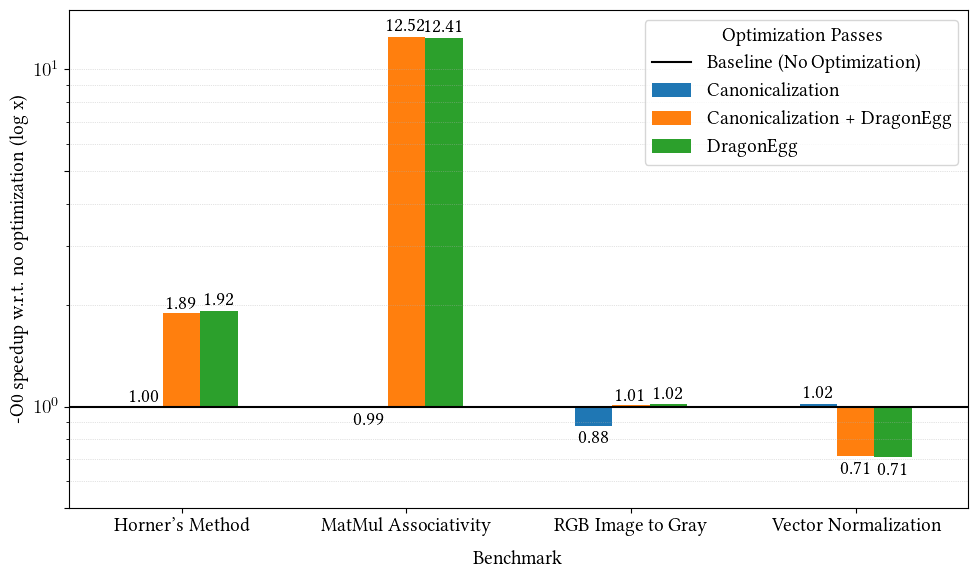

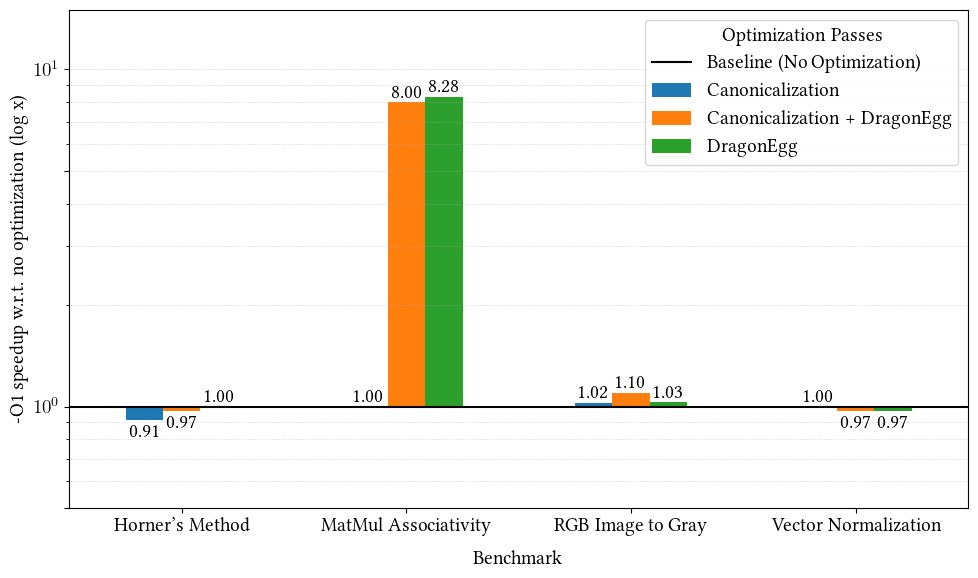

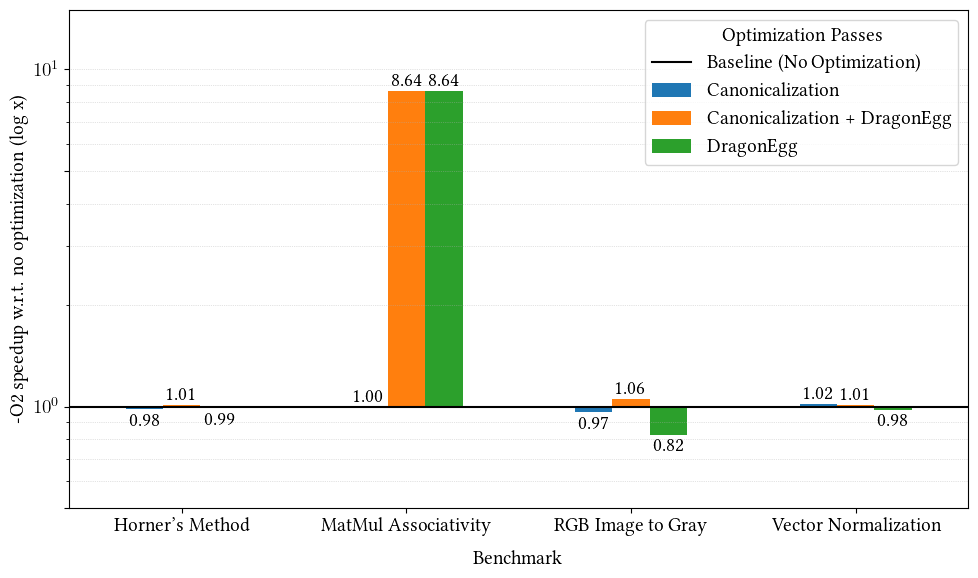

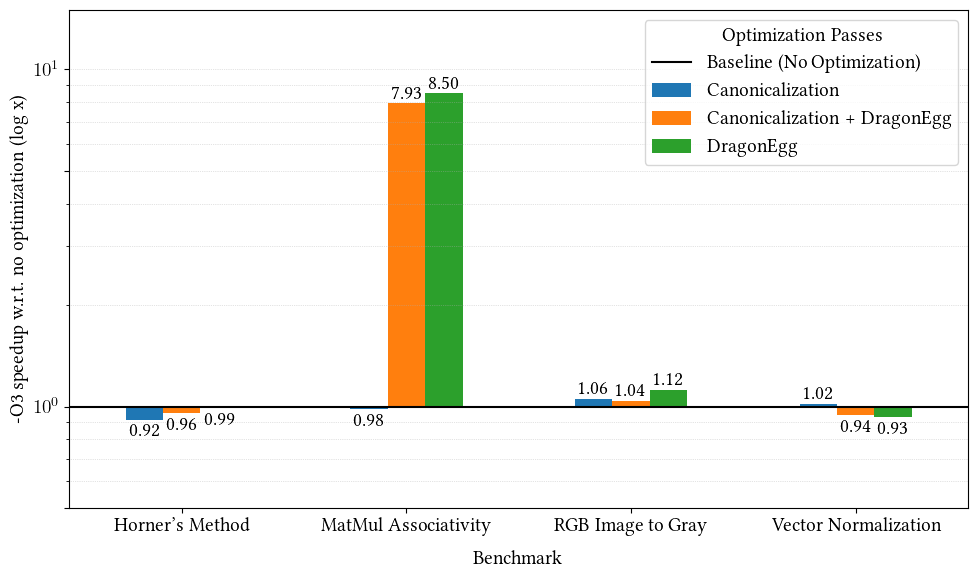

In [65]:
# create 1 speedup plot for each opt level: [-O0, -O1, -O2, -O3]
# the baseline is opt=noopt
for opt_level in ["-O0", "-O1", "-O2", "-O3"]:
    # Filter the dataframe for the current optimization level
    df_opt = df[['name', 'opt', opt_level]]
    
    # Pivot the dataframe to have optimizations as columns
    df_pivot = df_opt.pivot(index='name', columns='opt', values=opt_level)
    df_pivot = df_pivot.drop(columns=['DragonEgg + Canonicalization'], errors='ignore')
    
    # Calculate speedup relative to 'noopt'
    df_speedup = (1.0 / df_pivot).mul(df_pivot['No Optimization'], axis=0) 
    df_speedup = df_speedup.drop(columns=['No Optimization'], errors='ignore')

    # Create the speedup plot
    ax = df_speedup.plot(kind='bar', figsize=(10, 6))
    plt.grid(True, which='both', axis='y', zorder=0, linestyle=':', linewidth=0.5, alpha=0.7)
    plt.rcParams.update({'font.size': 14})

    # Customize the plot
    plt.xlabel('Benchmark', labelpad=10, fontdict={'family': 'Libertine'})
    plt.ylabel(f'{opt_level} speedup w.r.t. no optimization (log x)', fontdict={'family': 'Libertine'})
    plt.axhline(y=1, color='black', linestyle='-', label='Baseline (No Optimization)')
    plt.legend(title='Optimization Passes', loc='upper right')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0, ha='center')
    plt.yscale('log')
    plt.ylim(0.5, 15)
    plt.yticks([0.5, 1, 5, 10])

    # Add speedup numbers on top of each bar
    for container in ax.containers:
        # ax.bar_label(container, fmt='%.2f')
        for bar in container:
            bar_height = bar.get_height()
            bar.set_height(bar_height - 1)
            bar.set_y(1)

            # label under the bar if bar_height < 1
            if bar_height < 1:
                ax.text(bar.get_x() + bar.get_width() / 2, bar_height - 0.02, f'{bar_height:.2f}', ha='center', va='top', fontsize=14)
            else:
                ax.text(bar.get_x() + bar.get_width() / 2, bar_height, f'{bar_height:.2f}', ha='center', va='bottom', fontsize=14)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # save the plot to a file
    # plt.savefig(f"../bench/speedup{opt_level}.png")
    # plt.savefig(f"/Users/aziz/Documents/2-School/Research Summer 2024/paper/assets/speedup{opt_level}.png")

    plt.show()

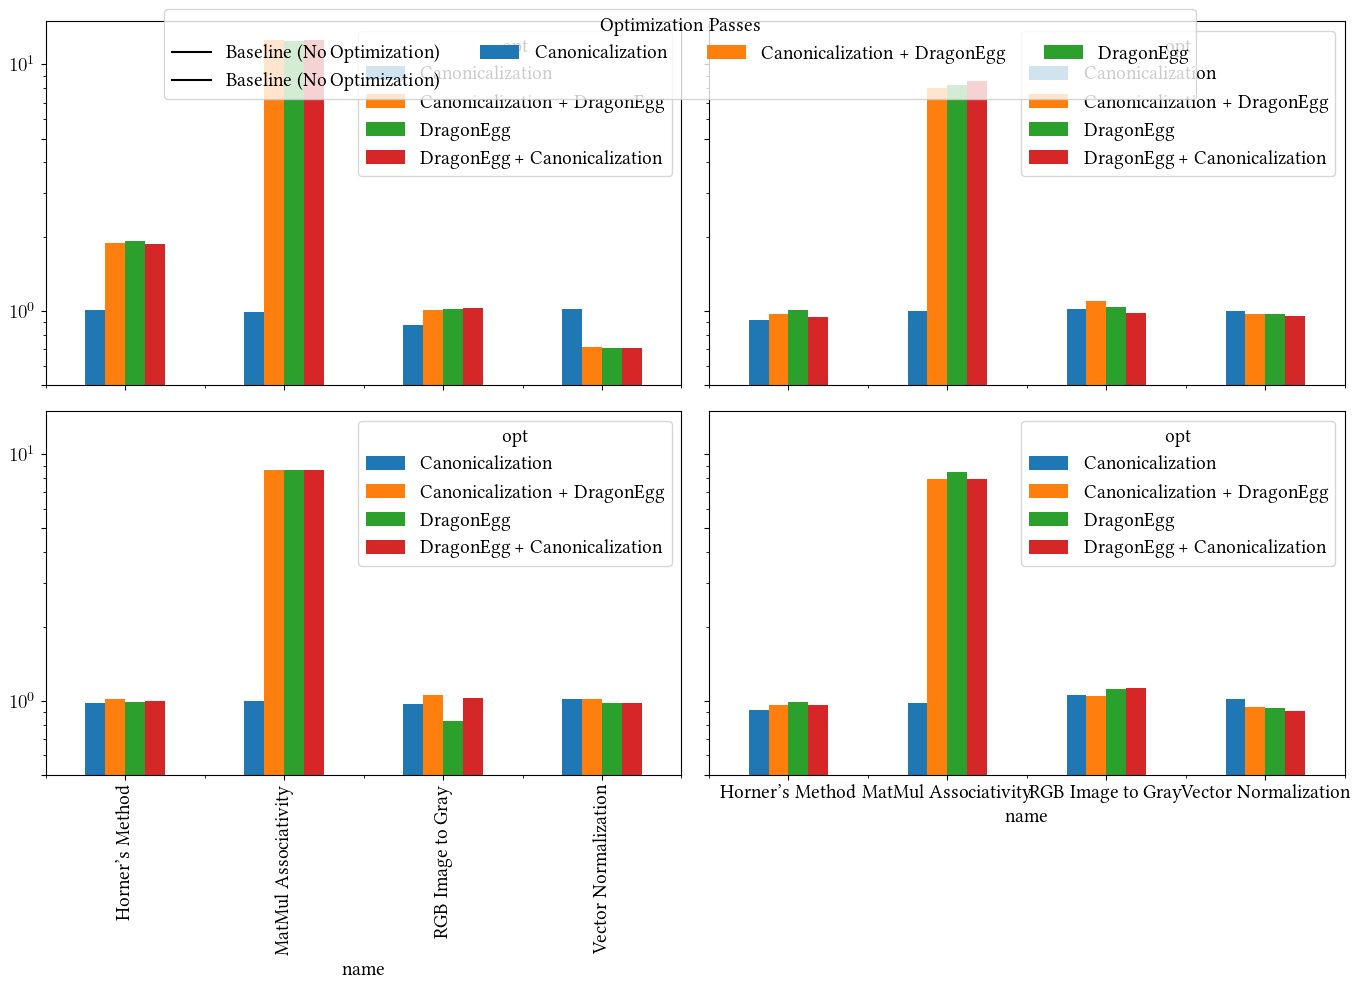

In [66]:
# All 4 plots in a 2x2 figure

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey=True, sharex=True)  # 2 rows, 2 columns
handles, labels = [], []

# create 1 speedup plot for each opt level: [-O0, -O1, -O2, -O3]
# the baseline is opt=noopt
for i, opt_level in enumerate(["-O0", "-O1", "-O2", "-O3"]):
    # Filter the dataframe for the current optimization level
    df_opt = df[['name', 'opt', opt_level]]
    
    # Pivot the dataframe to have optimizations as columns
    df_pivot = df_opt.pivot(index='name', columns='opt', values=opt_level)
    df_pivot = df_pivot.drop(columns=['Equality Saturation + Canonicalization'], errors='ignore')
    
    # Calculate speedup relative to 'noopt'
    df_speedup = (1.0 / df_pivot).mul(df_pivot['No Optimization'], axis=0) 
    df_speedup = df_speedup.drop(columns=['No Optimization'], errors='ignore')

    # Create the speedup plot
    df_speedup.plot(kind='bar', ax=axs[i // 2, i % 2])
    ax.grid(True, which='both', axis='y', zorder=0, linestyle=':', linewidth=0.5, alpha=0.7)
    ax.axhline(y=1, color='black', linestyle='-', label='Baseline (No Optimization)')

    if i % 2 == 0:  # left column
        ax.set_ylabel(f'{opt_level} speedup w.r.t. no optimization (log x)', fontdict={'family': 'Libertine'})

    if i // 2 == 1:
        ax.set_xlabel('Benchmark', labelpad=10, fontdict={'family': 'Libertine'})
    
    # no legend
    ax.legend().set_visible(False)

    # Add speedup numbers on top of each bar
    for container in ax.containers:
        # ax.bar_label(container, fmt='%.2f')
        for bar in container:
            bar_height = bar.get_height()
            bar.set_height(bar_height - 1)
            bar.set_y(1)

            # label under the bar if bar_height < 1
            if bar_height < 1:
                ax.text(bar.get_x() + bar.get_width() / 2, bar_height - 0.02, f'{bar_height:.2f}', ha='center', va='top', fontsize=14)
            else:
                ax.text(bar.get_x() + bar.get_width() / 2, bar_height, f'{bar_height:.2f}', ha='center', va='bottom', fontsize=14)
    
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()

for ax in axs.flat:
    ax.label_outer()
# Customize the plot
plt.rcParams.update({'font.size': 14})
fig.legend(handles, labels, loc='upper center', ncol=4, title="Optimization Passes")


# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='center')
plt.yscale('log')
plt.ylim(0.5, 15)
plt.yticks([0.5, 1, 5, 10])

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# save the plot to a file
plt.savefig("../bench/speedup.png")
plt.savefig("/Users/aziz/Documents/2-School/Research Summer 2024/paper/assets/speedup.png")